In [25]:
import os

import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import GridSearchCV

from matplotlib import pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

In [26]:
cleaned_datasets_path = os.path.abspath(os.path.join('cleaned_datasets'))

def load_dataset(filename):
    file_path = os.path.join(cleaned_datasets_path, filename)
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File {file_path} does not exist.")
    
    return pd.read_csv(file_path)

df_sale = load_dataset('rumah123_2025_sale_properties_cleaned.csv')
df_rent = load_dataset('rumah123_2025_rent_properties_cleaned.csv')
df_sale_2023 = load_dataset('rumah123_2023_sale_properties_cleaned.csv')

### 2023 Property Sale Price Prediction Model

In [27]:
X = df_sale_2023.drop(['price_in_rp', 'url', 'title', 'description'], axis=1).copy()
X_encoded = pd.get_dummies(X, columns=['city', 'district', 'certificate', 'property_condition'], drop_first=True, dtype=int, prefix='cat')

y = df_sale_2023['price_in_rp'].copy()

In [28]:
# Prepare the dataset for sale properties in 2023. We want to make sure the 2023_sale dataset have the same OHE features as the 2025_sale dataset.
df_sale_2025 = df_sale.copy()
X_sale_2025 = df_sale_2025.drop(['price_in_rp', 'url', 'title', 'description'], axis=1).copy()
X_sale_2025_encoded = pd.get_dummies(X_sale_2025, columns=['city', 'district', 'certificate', 'property_condition'], drop_first=True, dtype=int, prefix='cat')

In [29]:
for i in X_encoded.columns:
    if i not in X_sale_2025_encoded.columns:
        X_sale_2025_encoded[i] = 0
    

for i in X_sale_2025_encoded.columns:
    if i not in X_encoded.columns:
        X_encoded[i] = 0
        
X_sale_2025_encoded = X_sale_2025_encoded[X_encoded.columns]

for i, val in enumerate(X_encoded.columns):
    if val != X_sale_2025_encoded.columns[i]:
        print(i, val, X_sale_2025_encoded.columns[i])
        X_sale_2025_encoded.drop(val, axis=1, inplace=True)
        break

X_sale_to_sale_2025 = X_sale_2025_encoded.copy()
print(X_sale_2025_encoded.shape, X_encoded.shape)

251 cat_Tangerang Kota cat_Tangerang
(1739, 280) (2056, 280)


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.1, random_state=42)

In [31]:
# Log-transform the target variable to reduce skewness and improve model performance
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

#### Hyperparameter Tuning

In [8]:
# Hyperparameter tuning
'''
- n_estimators
- learning_rate
- max_depth
- subsample
- colsample_bytree
- gamma
- lambda alpha
'''

param_grid = {
    "n_estimators": [200, 500, 1000],
    "learning_rate": [0.01, 0.1],
    "max_depth": [3, 7],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "gamma": [0, 0.1],
}

grid_search = GridSearchCV(estimator=xgb.XGBRegressor(), param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=1)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


KeyboardInterrupt: 

In [ ]:
grid_search.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

#### 2023 Model Training

In [32]:
sale_2023_model = xgb.XGBRegressor(objective='reg:squarederror',
                            n_estimators=1000,
                            learning_rate=0.01,
                            max_depth=7,
                            subsample=1.0,
                            colsample_bytree=0.8,
                            gamma=0,
                            random_state=42)
sale_2023_model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [33]:
# RMSE in log-scale
reg_xgb_pred = sale_2023_model.predict(X_test)  # in log-scale
rmse_log = np.sqrt(MSE(y_test, reg_xgb_pred))
print(rmse_log)

0.34179111958143416


In [34]:
# RMSE in rupiah
y_test_rp = np.expm1(y_test)
reg_xgb_pred_rp = np.expm1(reg_xgb_pred)

mse_rupiah = MSE(y_test_rp, reg_xgb_pred_rp)
rmse_rupiah = np.sqrt(mse_rupiah)
rmse_rupiah

np.float64(530363298.99135756)

In [35]:
# inference example (expm1 is used to back-transform the logₑ(price) to actual Rupiah price)
pred_log = sale_2023_model.predict(X_test)         # model outputs logₑ(price)
pred_price = np.expm1(pred_log)                     # back to actual Rupiah
print(pred_price)

[1.05054950e+09 2.12613478e+09 1.53622746e+09 1.90517517e+09
 2.07914598e+09 6.29361088e+08 1.37696550e+09 1.56764173e+09
 8.15778432e+08 5.09531232e+08 1.28296397e+09 3.89110400e+09
 9.71784768e+08 5.39818112e+08 4.55707290e+09 3.73399392e+08
 2.77769779e+09 9.82107776e+08 3.47737280e+08 1.80637965e+09
 8.88774656e+08 8.15395712e+08 1.18165798e+09 9.28154112e+08
 4.31270707e+09 3.85577280e+08 8.56070656e+08 6.30987392e+08
 1.03556506e+09 4.98336832e+08 1.27427942e+09 3.73002912e+08
 4.81105984e+08 4.30009037e+09 3.64934016e+08 3.79411264e+08
 1.52327846e+09 1.80534285e+09 8.06446592e+08 1.36542669e+09
 7.02046848e+08 3.06327526e+09 2.42168858e+09 1.06587475e+09
 7.14123264e+08 1.78112051e+09 6.06525312e+08 3.94700877e+09
 5.76537088e+08 3.76807987e+09 9.52861568e+08 1.77766554e+09
 1.23824883e+09 6.67995392e+08 9.01083264e+08 5.27075968e+08
 1.71694605e+09 3.02198502e+09 1.28300314e+09 2.81345459e+09
 4.16720032e+08 6.50853184e+08 2.13234842e+09 2.18152115e+09
 1.02868672e+09 1.368116

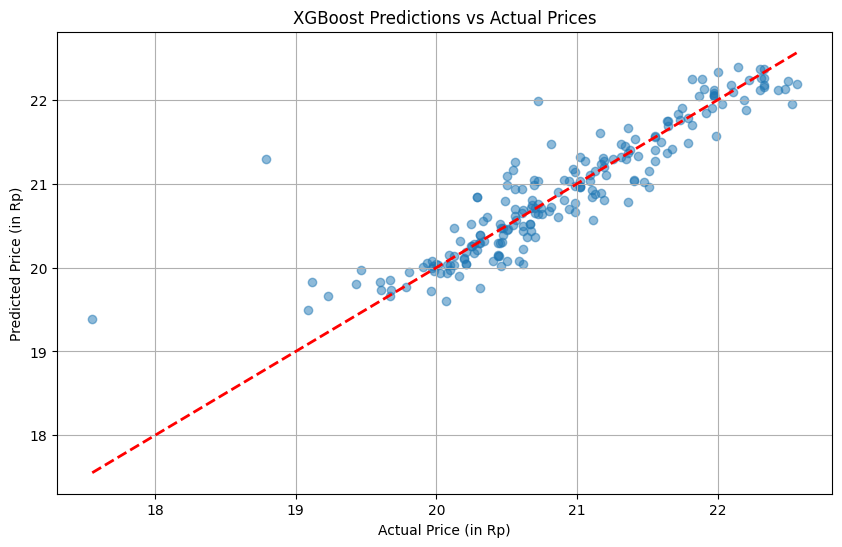

In [36]:
# visualize predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, reg_xgb_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price (in Rp)')
plt.ylabel('Predicted Price (in Rp)')
plt.title('XGBoost Predictions vs Actual Prices')
plt.grid()
plt.show()

### 2025 Property Rent Price Prediction Model

In [37]:
X_rent = df_rent.drop(['rent_price_per_year', 'url', 'title', 'description'], axis=1).copy()
X_rent_encoded = pd.get_dummies(X_rent, columns=['city', 'district', 'certificate', 'property_condition'], drop_first=True, dtype=int, prefix='cat')

y_rent = df_rent['rent_price_per_year'].copy()

In [38]:
# Prepare the dataset for rent properties in 2025. We want to make sure the 2023_sale dataset have the same OHE features as the 2025_rent dataset.
df_sale_2025 = df_sale.copy()
X_sale_2025 = df_sale_2025.drop(['price_in_rp', 'url', 'title', 'description'], axis=1).copy()
X_sale_2025_encoded = pd.get_dummies(X_sale_2025, columns=['city', 'district', 'certificate', 'property_condition'], drop_first=True, dtype=int, prefix='cat')

In [39]:
X_rent_encoded = X_rent_encoded.loc[:, ~X_rent_encoded.columns.duplicated()]
X_sale_2025_encoded = X_sale_2025_encoded.loc[:, ~X_sale_2025_encoded.columns.duplicated()]

all_columns = sorted(set(X_rent_encoded.columns).union(X_sale_2025_encoded.columns))

X_rent_encoded = X_rent_encoded.reindex(columns=all_columns, fill_value=0)
X_sale_2025_encoded = X_sale_2025_encoded.reindex(columns=all_columns, fill_value=0)
        
X_sale_2025_encoded = X_sale_2025_encoded[X_rent_encoded.columns]

for i, val in enumerate(X_rent_encoded.columns):
    if val != X_sale_2025_encoded.columns[i]:
        X_sale_2025_encoded.drop(val, axis=1, inplace=True)
        if X_sale_2025_encoded.shape[1] == X_rent_encoded.shape[1]:
            break

print(X_sale_2025_encoded.shape, X_rent_encoded.shape)

X_rent_to_sale_2025 = X_sale_2025_encoded.copy()

(1739, 347) (2499, 347)


In [40]:
X_rent_train, X_rent_test, y_rent_train, y_rent_test = train_test_split(X_rent_encoded, y_rent, test_size=0.1, random_state=42)

In [41]:
# Log-transform the target variable to reduce skewness and improve model performance
y_rent_train = np.log1p(y_rent_train)
y_rent_test = np.log1p(y_rent_test)

In [42]:
rent_2025_model = xgb.XGBRegressor(objective='reg:squarederror',
                            n_estimators=1000,
                            learning_rate=0.01,
                            max_depth=7,
                            subsample=1.0,
                            colsample_bytree=0.8,
                            gamma=0,
                            random_state=42)
rent_2025_model.fit(X_rent_train.to_numpy(), y_rent_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [43]:
# rmse in log-scale
rent_2025_pred = rent_2025_model.predict(X_rent_test.to_numpy())
rmse_log = np.sqrt(MSE(y_rent_test, rent_2025_pred))
print(rmse_log)

0.3331002043511417


In [44]:
# rmse in rupiah
y_rent_test_rp = np.expm1(y_rent_test)
rent_2025_pred_rp = np.expm1(rent_2025_pred)
mse_rupiah = MSE(y_rent_test_rp, rent_2025_pred_rp)
rmse_rupiah = np.sqrt(mse_rupiah)
print(rmse_rupiah)

59601644.84927854


In [45]:
# inference example (expm1 is used to back-transform the logₑ(price) to actual Rupiah price)
pred_log = rent_2025_model.predict(X_rent_test.to_numpy())  # model outputs logₑ(price)
pred_price = np.expm1(pred_log)  # back to actual Rupiah
print(pred_price)

[7.24159120e+07 4.18529824e+08 3.72604704e+08 1.65097488e+08
 1.24954152e+08 4.74037320e+07 9.05434640e+07 7.65061440e+07
 7.24584640e+07 2.11022784e+08 5.05786880e+08 2.24488120e+07
 3.17098120e+07 2.69069920e+07 8.00026880e+07 3.99266240e+07
 6.48373520e+07 2.73440800e+08 1.12800144e+08 1.75391056e+08
 6.47652960e+07 3.84271168e+08 4.18222360e+07 8.93628960e+07
 1.94201696e+08 7.15107040e+07 2.48474928e+08 5.27685280e+07
 4.22963648e+08 1.56084736e+08 4.45134280e+07 5.16913920e+08
 9.44701360e+07 4.23989240e+07 2.54699904e+08 1.52738848e+08
 2.20162080e+07 6.80689520e+07 2.19268736e+08 3.43277888e+08
 4.44938400e+08 7.35460560e+07 8.86050800e+07 3.97929888e+08
 3.33949760e+08 6.02676880e+07 3.25607104e+08 5.86752960e+07
 1.10885192e+08 5.98211520e+07 1.03170632e+08 4.37193056e+08
 6.04926040e+07 3.58278528e+08 2.33327000e+07 7.55371280e+07
 5.16718752e+08 5.46679240e+07 8.34722320e+07 3.46528800e+07
 3.17354640e+07 3.58156896e+08 1.87637792e+08 8.86257040e+07
 6.84982240e+07 4.838381

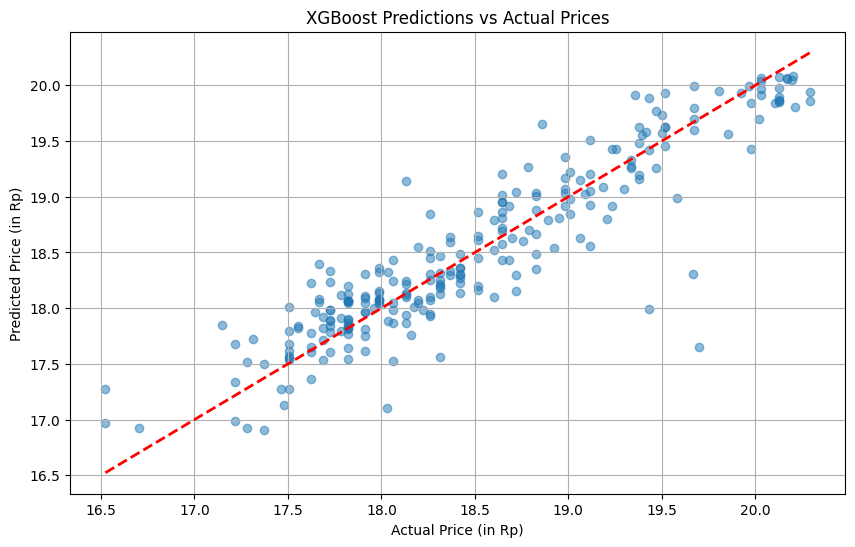

In [46]:
# visualize predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_rent_test, rent_2025_pred, alpha=0.5)
plt.plot([y_rent_test.min(), y_rent_test.max()], [y_rent_test.min(), y_rent_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price (in Rp)')
plt.ylabel('Predicted Price (in Rp)')
plt.title('XGBoost Predictions vs Actual Prices')
plt.grid()
plt.show()

### 2025 Property Sale Investment Features Integration 

In [54]:
# Add Property Sale Investment Features
df_sale_2025 = df_sale.copy()

# 2023 price for 2025 dataset
df_sale_2025['price_in_rp_2023'] = np.expm1(sale_2023_model.predict(X_sale_to_sale_2025.to_numpy()))

# 2025 rent for 2025 dataset
df_sale_2025['rent_price_per_year_2025'] = np.expm1(rent_2025_model.predict(X_rent_to_sale_2025.to_numpy()))

df_sale_2025['rent_cap_rate'] = df_sale_2025['rent_price_per_year_2025'] / df_sale_2025['price_in_rp_2023'] * 100
df_sale_2025['rent_cap_rate'].sum() / df_sale_2025.shape[0]

np.float32(5.00861)

In [55]:
# --- Calculate the Compound Annual Growth Rate (CAGR) ---

# Define the number of years between the two price points
num_years = 2025 - 2023

# Calculate the property value growth rate (CAGR)
# Adding a small number (epsilon) to the denominator to avoid division by zero errors
epsilon = 1e-9
df_sale_2025['property_value_growth'] = \
    ((df_sale_2025['price_in_rp'] / (df_sale_2025['price_in_rp_2023'] + epsilon)) ** (1/num_years)) - 1

# Display the first few rows with the new column
print(df_sale_2025[['price_in_rp_2023', 'price_in_rp', 'property_value_growth']].head())

   price_in_rp_2023   price_in_rp  property_value_growth
0      8.139894e+08  5.900000e+08              -0.148633
1      1.376209e+09  2.040000e+09               0.217511
2      3.389998e+08  3.400000e+08               0.001474
3      6.477978e+08  8.400000e+08               0.138728
4      1.757770e+09  2.770000e+09               0.255333


In [56]:
# --- Assumptions ---
discount_rate = 0.10
holding_period_years = 2
rent_growth_rate = 0.03 # You could even calculate this if you have historical rent data
operating_expense_ratio = 0.30

# --- NPV Calculation using the new dynamic growth rate ---

# Year 1 NOI
noi_year_1 = df_sale_2025['rent_price_per_year_2025'] * (1 - operating_expense_ratio)

# Year 2 NOI
noi_year_2 = noi_year_1 * (1 + rent_growth_rate)

# Estimated Future Sale Price (Terminal Value)
# Using the calculated 'property_value_growth' for each property
# Projecting from the most recent price, 'price_in_rp'
future_sale_price = df_sale_2025['price_in_rp'] * \
    (1 + df_sale_2025['property_value_growth']) ** holding_period_years

# Calculate Present Value of all cash flows
pv_noi_year_1 = noi_year_1 / (1 + discount_rate) ** 1
pv_noi_year_2 = noi_year_2 / (1 + discount_rate) ** 2
pv_future_sale_price = future_sale_price / (1 + discount_rate) ** holding_period_years

# Calculate Final NPV
# Assuming 'price_in_rp' is the acquisition cost in 2025
df_sale_2025['NPV_final'] = pv_noi_year_1 + pv_noi_year_2 + pv_future_sale_price - df_sale_2025['price_in_rp']

In [57]:
df_sale_2025.query('property_value_growth > 0').shape[0]

1128

In [58]:
df_sale_2025.shape[0]

1739

In [59]:
df_sale_2025.sort_values('NPV_final', ascending=False).head(20)

,url,title,price_in_rp,district,city,bedrooms,bathrooms,land_size_m2,building_size_m2,certificate,electricity_power,property_condition,floor_count,description,price_in_rp_2023,rent_price_per_year_2025,rent_cap_rate,property_value_growth,NPV_final
481,https://www.rumah123.com/properti/jakarta-utar...,"Turun Harga, Jual Cepat Rumah Rapih Siap Huni ...",3.500000e+09,Kelapa Gading,Jakarta Utara,3.0,3.0,90.0,1.0,SHM,11000.0,Bagus,3.0,"Turun Harga, Jual Cepat Rumah Rapih Siap Huni ...",5.788510e+08,85683472.0,14.802337,1.458955,1.409534e+10
993,https://www.rumah123.com/properti/tangerang/ho...,Rumah SHM 3 Lt Sudah Renov 15 Menit ke RS Mitr...,7.330000e+09,Gading Serpong,Tangerang,5.0,5.0,120.0,208.0,SHM,0.0,Bagus,3.0,Cluster Kazumi at The Zora BSD City\nPagedanga...,2.119761e+09,126495568.0,5.967444,0.859553,1.377354e+10
56,https://www.rumah123.com/properti/jakarta-sela...,Rumah 2 Lantai Di Cilandak Cipete Dekat Ke Sta...,9.000000e+09,Cilandak,Jakarta Selatan,5.0,5.0,270.0,216.0,SHM,0.0,Bagus,2.0,Dijual rumah area cipete kecamatan cilandak - ...,3.305192e+09,232957584.0,7.048232,0.650148,1.154069e+10
9,https://www.rumah123.com/properti/depok/hos177...,Rumah 2 Lantai Semi Furnished Siap Huni Lingku...,9.000000e+09,Cinere,Depok,5.0,4.0,420.0,600.0,SHM,7700.0,Bagus,2.0,*SPESIFIKASI TAMBAHAN*\n1. Lantai bawah terdir...,3.344931e+09,311132928.0,9.301626,0.640317,1.139640e+10
28,https://www.rumah123.com/properti/jakarta-utar...,Jual Rumah Katamaran Indah Pik 8x25 Rapi Siap ...,8.000000e+09,Pantai Indah Kapuk,Jakarta Utara,3.0,2.0,200.0,150.0,SHM,6600.0,Bagus,2.0,Jual rumah Katamaran Indah PIK 8x25 rapi \n\nL...,2.875497e+09,153979376.0,5.354878,0.667971,1.058397e+10
561,https://www.rumah123.com/properti/tangerang/ho...,Cluster Carson Spek Mewah 5m,5.000000e+09,Gading Serpong,Tangerang,3.0,2.0,122.0,155.0,SHM,0.0,Bagus,2.0,Cluster Carson Gading Serpong\nTipe Premium\n2...,1.342884e+09,68939800.0,5.133712,0.929593,1.047061e+10
208,https://www.rumah123.com/properti/depok/hos392...,RUMAH MODERN 3.5 LANTAI DALAM CLUSTER DEKAT TO...,7.710000e+09,Cinere,Depok,7.0,8.0,382.0,724.0,SHM,11000.0,Bagus,4.0,Rumah bergaya modern di Cinere.\n\nTemukan rum...,2.810360e+09,321373856.0,11.435327,0.656327,1.016681e+10
522,https://www.rumah123.com/properti/jakarta-sela...,Rumah Baru Siap Huni Dekat Pondok Indah Mall Shm,9.000000e+09,Pondok Indah,Jakarta Selatan,4.0,5.0,120.0,255.0,SHM,0.0,Bagus,3.0,"JUAL RUMAH BARU DI PONDOK INDAH, JAKARTA SELAT...",3.604048e+09,203494448.0,5.646276,0.580251,9.824910e+09
355,https://www.rumah123.com/properti/jakarta-utar...,"Jual Cepat, Rumah Rapih 2Lantai Siap Huni Di S...",3.300000e+09,Sunter,Jakarta Utara,4.0,3.0,128.0,1.0,SHM,7700.0,Bagus,2.0,"Jual Cepat, Rumah Rapih 2Lantai Siap Huni Di S...",6.945880e+08,103031400.0,14.833455,1.179683,9.784279e+09
1044,https://www.rumah123.com/properti/tangerang/ho...,Rumah Mewah Kolam Renang Di Cluster Elite Nava...,8.900000e+09,BSD,Tangerang,3.0,3.0,220.0,285.0,SHM,7700.0,Bagus,3.0,Rumah mewah bergaya modern dengan swimming poo...,3.584674e+09,193241376.0,5.390766,0.575688,9.599979e+09


In [60]:
df_sale_2025.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1739 entries, 0 to 1738
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   url                       1739 non-null   object 
 1   title                     1739 non-null   object 
 2   price_in_rp               1739 non-null   float64
 3   district                  1739 non-null   object 
 4   city                      1739 non-null   object 
 5   bedrooms                  1739 non-null   float64
 6   bathrooms                 1739 non-null   float64
 7   land_size_m2              1739 non-null   float64
 8   building_size_m2          1739 non-null   float64
 9   certificate               1739 non-null   object 
 10  electricity_power         1739 non-null   float64
 11  property_condition        1739 non-null   object 
 12  floor_count               1739 non-null   float64
 13  description               1739 non-null   object 
 14  price_in

In [61]:
df_sale_2025.query('NPV_final > 0').sort_values(by='NPV_final', ascending=False).count()

url                         868
title                       868
price_in_rp                 868
district                    868
city                        868
bedrooms                    868
bathrooms                   868
land_size_m2                868
building_size_m2            868
certificate                 868
electricity_power           868
property_condition          868
floor_count                 868
description                 868
price_in_rp_2023            868
rent_price_per_year_2025    868
rent_cap_rate               868
property_value_growth       868
NPV_final                   868
dtype: int64

In [62]:
df_sale_2025.sort_values(by='NPV_final', ascending=False).loc[:, 'district'].head(20)

481          Kelapa Gading
993         Gading Serpong
56                Cilandak
9                   Cinere
28      Pantai Indah Kapuk
561         Gading Serpong
208                 Cinere
522           Pondok Indah
355                 Sunter
1044                   BSD
436           Pondok Indah
1398                Sunter
309                    BSD
1388         BSD The Green
1357          Pondok Indah
212           Pondok Indah
416                    BSD
1319              Cilandak
33             Alam Sutera
32             Alam Sutera
Name: district, dtype: object

In [63]:
def format_rupiah(price_rp):
    """
    Converts a large Rupiah value into a more readable string format
    (e.g., "1 Miliar", "100 Juta").
    """
    if pd.isna(price_rp):
        return np.nan # Handle NaN values if any

    price = int(price_rp) # Convert to int for easier comparison

    if price >= 1_000_000_000_000:
        return f"{price / 1_000_000_000_000:.0f} Triliun"
    elif price >= 1_000_000_000:
        return f"{price / 1_000_000_000:.0f} Miliar"
    elif price >= 1_000_000:
        return f"{price / 1_000_000:.0f} Juta"
    elif price >= 1_000:
        return f"{price / 1_000:.0f} Ribu"
    else:
        return str(price)

# See the number of listings per district
print("Listings per district:")
print(df_sale_2025['district'].value_counts())

# Get a statistical summary of prices for each district,
# and then apply the formatting for display
print("\nPrice summary by district (formatted for display):")

# Calculate the descriptive statistics first
price_summary = df_sale_2025.sort_values('NPV_final', ascending=False).groupby('district')['price_in_rp'].describe().round(2)

# Create a copy to apply string formatting for display
price_summary_display = price_summary.copy()

# Apply the formatting function to relevant columns for display
for col in ['mean', 'min', 'max', '25%', '50%', '75%']:
    if col in price_summary_display.columns:
        price_summary_display[col] = price_summary_display[col].apply(format_rupiah)

print(price_summary_display)

Listings per district:
district
BSD                                 146
BSD City                             98
Gading Serpong                       87
Kelapa Gading                        63
Cibubur                              63
Cakung                               47
Sunter                               47
Pantai Indah Kapuk                   44
Cipayung                             37
Kota Wisata                          35
Harapan Indah                        33
Alam Sutera                          33
Summarecon Bekasi                    33
Sentul City                          31
Cibinong                             30
Jagakarsa                            29
Cinere                               28
Pantai Indah Kapuk 2                 27
Green Lake City                      26
Jati Asih                            25
Pancoran Mas                         25
Bojong Gede                          25
Bogor Barat                          24
Bekasi Utara                         23
Sawangan

In [64]:
# See the number of listings per city (WITHOUT FORMATTING)

print("Listings per city:")
print(df_sale_2025['city'].value_counts())

# Get a statistical summary of prices for each city
print("\nPrice summary by city (in Billion Rp):")
print((df_sale_2025.groupby('city')['price_in_rp']).describe().round(2))

Listings per city:
city
Tangerang          437
Bogor              234
Depok              225
Bekasi             193
Jakarta Timur      192
Jakarta Utara      191
Jakarta Barat      136
Jakarta Selatan    110
Jakarta Pusat       21
Name: count, dtype: int64

Price summary by city (in Billion Rp):
                 count          mean           std          min           25%  \
city                                                                            
Bekasi           193.0  1.031974e+09  7.863123e+08  330000000.0  6.000000e+08   
Bogor            234.0  1.186120e+09  1.069261e+09  325000000.0  5.900000e+08   
Depok            225.0  1.247996e+09  1.063387e+09  340000000.0  7.200000e+08   
Jakarta Barat    136.0  3.174412e+09  1.829216e+09  670000000.0  1.872500e+09   
Jakarta Pusat     21.0  1.576048e+09  1.433864e+09  403000000.0  7.380000e+08   
Jakarta Selatan  110.0  4.235518e+09  2.525789e+09  740000000.0  1.870000e+09   
Jakarta Timur    192.0  1.580141e+09  1.116118e+09  360

In [65]:
# Top 15 districts by average NPV
print("Top districts by average NPV:")
print(df_sale_2025.groupby('district')['NPV_final'].mean().sort_values(ascending=False).head(15))

# Top 15 districts by average historical property growth
print("\nTop districts by average property value growth:")
print(df_sale_2025.groupby('district')['property_value_growth'].mean().sort_values(ascending=False).head(15))

Top districts by average NPV:
district
BSD The Green     8.612676e+09
Mampang           5.579965e+09
Pantai Mutiara    5.578435e+09
Kebayoran Lama    5.511905e+09
Kemandoran        5.462651e+09
Pondok Indah      4.703659e+09
BSD The Icon      3.601416e+09
Golf Island       3.146358e+09
Menteng           2.984520e+09
Cipete            2.932017e+09
Bekasi Barat      2.848365e+09
Kemang            2.702678e+09
BSD Eminent       2.229766e+09
Tebet             2.209893e+09
Permata Buana     2.142475e+09
Name: NPV_final, dtype: float64

Top districts by average property value growth:
district
BSD Nusaloka      0.716624
Menteng           0.578895
BSD The Green     0.524036
Kebayoran Lama    0.463896
Kemandoran        0.459263
Mampang           0.390132
Pondok Indah      0.385068
Pantai Mutiara    0.384276
BSD The Icon      0.384024
BSD Vanya Park    0.371865
BSD Green Cove    0.327266
BSD Eminent       0.325405
Cipete            0.287697
Golf Island       0.283576
Sumur Batu        0.282649
N

In [66]:
# Create a Return on Investment (ROI) metric
df_sale_2025['ROI_pct'] = (df_sale_2025['NPV_final'] / df_sale_2025['price_in_rp']) * 100

# Sort by this new ROI metric
# Note how the most expensive properties may no longer be at the top
print("Top 20 properties by ROI:")
print(df_sale_2025.sort_values(by='ROI_pct', ascending=False)[['district', 'price_in_rp', 'NPV_final', 'ROI_pct']].head(20))

# Find the districts with the best average ROI
print("\nTop 15 districts by average ROI:")
print(df_sale_2025.groupby('district')['ROI_pct'].mean().sort_values(ascending=False).head(15))

Top 20 properties by ROI:
                district   price_in_rp     NPV_final     ROI_pct
481        Kelapa Gading  3.500000e+09  1.409534e+10  402.724139
1398              Sunter  2.750000e+09  9.353048e+09  340.110834
355               Sunter  3.300000e+09  9.784279e+09  296.493314
507          Kota Wisata  1.700000e+09  3.778329e+09  222.254668
1449         Sentul City  2.400000e+09  5.203073e+09  216.794720
561       Gading Serpong  5.000000e+09  1.047061e+10  209.412179
1734            BSD City  1.410000e+09  2.777502e+09  196.985963
1532      Gading Serpong  1.350000e+09  2.609788e+09  193.317606
993       Gading Serpong  7.330000e+09  1.377354e+10  187.906371
826         BSD Nusaloka  1.250000e+09  1.831683e+09  146.534625
1170       Cempaka Putih  3.100000e+09  4.542033e+09  146.517193
1645       Kelapa Gading  3.500000e+09  5.102635e+09  145.789580
1548         Sentul City  7.800000e+08  1.135524e+09  145.579967
77           Kota Wisata  1.140000e+09  1.552936e+09  136.222480

In [67]:
# Calculate price per square meter
df_sale_2025['price_per_m2'] = df_sale_2025['price_in_rp'] / df_sale_2025['building_size_m2']

# Compare average price per m2 across districts
print("Districts with the lowest average price per square meter:")
print(df_sale_2025.groupby('district')['price_per_m2'].mean().sort_values().head(15))

Districts with the lowest average price per square meter:
district
Rawa Badak           2.578947e+06
Jonggol              7.350000e+06
Legenda Wisata       7.600000e+06
Bekasi Kota          8.015882e+06
BSD Residence One    8.771429e+06
Tenjo                9.027778e+06
Karang Tengah        9.333333e+06
Legok                9.444444e+06
Cilebut              9.675926e+06
Pesanggrahan         9.722222e+06
Pondok Cabe          9.900990e+06
Citayam              1.011823e+07
Cikarang             1.026667e+07
Tanah Baru           1.041667e+07
Tajur                1.045455e+07
Name: price_per_m2, dtype: float64


In [68]:
# Define your total investment budget
YOUR_BUDGET = 7_500_000_000 # Example: 7.5 Billion Rupiah

# Create a dataframe of candidates for the optimization model
# These are affordable properties with a positive expected return
candidates_df = df_sale_2025[
    (df_sale_2025['price_in_rp'] <= YOUR_BUDGET) &
    (df_sale_2025['NPV_final'] > 0)
].copy()

print(f"Found {len(candidates_df)} potential investment candidates within a {YOUR_BUDGET/1e9} Billion Rp budget.")

# This 'candidates_df' is what you will feed into your dynamic programming function.
# It should contain the 'price_in_rp' (weight) and 'NPV_final' (value) for each potential investment.
print(candidates_df[['district', 'price_in_rp', 'NPV_final', 'ROI_pct']].head())

Found 824 potential investment candidates within a 7.5 Billion Rp budget.
        district   price_in_rp     NPV_final    ROI_pct
1        Cibubur  2.040000e+09  5.320056e+08  26.078704
3    Bojong Sari  8.400000e+08  1.038107e+08  12.358419
4         Cinere  2.770000e+09  9.515736e+08  34.352837
7    Kota Wisata  3.900000e+08  1.153993e+08  29.589558
11  Citra Garden  2.650000e+09  1.299884e+07   0.490522
